In [2]:
from os import listdir
from os.path import join
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import joblib
import cv2
import numpy as np
from skimage import feature, exposure
import matplotlib.pyplot as plt
import random
import os
from sklearn.metrics import roc_curve, auc
import pickle
import re

#临时保存运行结果变量
def save(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
def load(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

def preprocessing(datasetpath):    
    dataset = []    
    dataset.extend([join(datasetpath, f).replace('\\','/') for f in listdir(datasetpath)])#我也不知道为什么要会出现\\
    data_lst=[cv2.imread(i) for i in dataset]
    return data_lst#返回'路径'

# 从每一张没有人的原始图片中随机裁出10张64*128的图片作为负样本
def sample_neg(full_neg_lst, neg_list, size):
    random.seed(1)
    width, height = size[1], size[0]
    for i in range(len(full_neg_lst)):
        for j in range(10):
            y = int(random.random() * (len(full_neg_lst[i]) - height))
            x = int(random.random() * (len(full_neg_lst[i][0]) - width))
            neg_list.append(full_neg_lst[i][y:y + height, x:x + width])
    return neg_list

class HOG:
    def __init__(self, orientations = 9, pixelsPerCell = (8, 8),
        cellsPerBlock = (2, 2), transform = False):
        self.orienations = orientations
        self.pixelsPerCell = pixelsPerCell
        self.cellsPerBlock = cellsPerBlock
        self.transform = transform
        
    def describe(self, image):
        hist = feature.hog(image, orientations = self.orienations,
                           pixels_per_cell = self.pixelsPerCell,
                           cells_per_block = self.cellsPerBlock,
                           transform_sqrt = self.transform)
        return hist

hog = HOG(transform = True)	   # 实例化HOG对象，并将 transform 参数设为 True
neg_list = []
pos_list = []
gradient_lst = []
labels = []
#获得gradient_lst和label_lst
pos_list = preprocessing(r'E:\dataset\inria\train_64x128_H96/posPatches')
full_neg_lst=preprocessing(r'E:\dataset\inria\train_64x128_H96\negPatches')
sample_neg(full_neg_lst, neg_list, [128, 64])

for img in pos_list:
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (64, 128), interpolation = cv2.INTER_AREA)#这句是干嘛的？
    gradient_lst.append(hog.describe(resized))
    labels.append(1)
for img in neg_list:
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (64, 128), interpolation = cv2.INTER_AREA)
    gradient_lst.append(hog.describe(resized))
    labels.append(0)

In [7]:
print("### Training model...")
clf = LogisticRegression(random_state=0, solver='liblinear').fit(gradient_lst,labels)
joblib.dump(clf, r"E:\hog_svm_test1\result_hog/logic_hog_1")

def resize(image, height = None, width = None):#测试图像的输入数据的size要合格
    h, w = image.shape[:2]
    dim = None
    
    if width is None and height is None:
        return image
    
    if width is None:
        dim = (int(w * (height / h)), height)
    else:
        dim = (width, int(h * (width / w)))
        
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

def coordinate_transformation(height, width, h, w, x, y, roi):
    if h == 0 or w == 0:
        print("divisor can not be zero !!")
    
    img_h = int(height/h * roi[1])
    img_w = int(width/w * roi[0])

    img_y = int(height/h * y)
    img_x = int(width/w * x)

    return (img_x, img_y, img_w, img_h) 

def sliding_window(image, window = (64, 128), step = 64):#参数：图像，窗口大小，窗口滑动步长
    for y in range(0, image.shape[0] - window[1], step):
        for x in range(0, image.shape[1] - window[0], step):
            yield (x, y, image[y:y + window[1], x:x + window[0]]) #返回yield生成的元组，窗口左上角坐标，窗口图像

def pyramid(image, top = (224, 224), ratio = 1.5):#参数：图像，最小（金字塔最顶层）size，每次缩减多少
    yield image#最底层的图像
    while True:
        (w, h) = (int(image.shape[1] / ratio), int(image.shape[0] / ratio))
        image = cv2.resize(image, (w, h), interpolation = cv2.INTER_AREA)
        if w < top[1] or h < top[0]:
            break
        
        yield image#每次返回一张缩小后的图像

def non_max_suppression(boxes, scores, threshold):
    """使用基于NMS的方法对边界框进行去重"""
    # 1. 按照置信度从高到低排序
    indices = np.argsort(scores)[::-1]
    boxes = boxes[indices]
    scores = scores[indices]

    # 2. 初始化一个空列表，用于存储去重后的边界框
    picked_boxes = []
    picked_scores = []

    # 3. 遍历排序后的边界框列表，执行NMS去重操作
    while len(boxes) > 0:
        # 将当前边界框加入去重后的边界框列表
        picked_boxes.append(boxes[0])
        picked_scores.append(scores[0])
        # 计算当前边界框与其它所有未处理的边界框的IoU
        iou = compute_iou(boxes[0], boxes[1:])
        # 将IoU值大于阈值的边界框从列表中移除
        boxes = boxes[1:][iou < threshold]
        scores = scores[1:][iou < threshold]
    
    temp=picked_boxes
    
    picked_boxes1=[]
    picked_scores1=[]
    #加一个判断boxes不能小于一个阈值
    for i in range(len(picked_boxes)):
        area=(picked_boxes[i][2]-picked_boxes[i][0])*(picked_boxes[i][3]-picked_boxes[i][1])
        if area > 15000:
            picked_boxes1.append(picked_boxes[i])
            picked_scores1.append(picked_scores[i])

    # 4. 返回去重后的边界框列表
    return picked_boxes1,picked_scores1

""" 图像金字塔与滑动窗口参数 """
ratio = 1.2
i_roi = (64, 128)
step = 32
top = (128,128)

def compute_iou(box, boxes):
    """计算box与boxes中所有边界框的IoU"""
    # 计算box的面积
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    # 计算boxes中所有边界框的面积
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    # 计算box与boxes中所有边界框的交集
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])
    w = np.maximum(0, x2 - x1)
    h = np.maximum(0, y2 - y1)
    inter = w * h

    # 计算box与boxes中所有边界框的并集
    iou = inter / (box_area + boxes_area - inter)

    return iou

model = joblib.load(r"E:\hog_svm_test1\result_hog/logic_hog_1")   # 加载模型对象
hog = HOG(transform = True)	   # 实例化HOG对象，并将 transform 参数设为 True

boxes_predict=[]    #用于存储每个预测值的picked_boxes和picked_scores
scores_predict=[]

img_path=r'E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/'
img_name_lst=os.listdir(img_path)
img_path_lst=[img_path+i for i in img_name_lst]
i=-1
for img_one in img_path_lst:
    
    print(img_one)
    i+=1
#     if i>10:
#         break
    img=cv2.imread(img_one)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape[:2]

    scores=[]
    boxes=[]
    for image in pyramid(gray, top = (128, 128), ratio = ratio):	# 每层滑动窗口进行resize，然后使用HOG将提取到的特征传给hist
        h, w = image.shape[:2]

        for (x, y, roi) in sliding_window(image, window = i_roi, step = step):
            roi = cv2.resize(roi, (64, 128), interpolation = cv2.INTER_AREA)   
            hist = hog.describe(roi)

            if model.predict([hist])[0]:	# 如果预测结果为真，也就是1，将进行下一步坐标变换
                scores.append(model.predict_proba([hist])[0][1])
                img_x, img_y, img_w, img_h = coordinate_transformation(height, width, h, w, x, y, i_roi) 
                boxes.append([img_x, img_y, img_w+img_x, img_h+img_y])	# 将顶点坐标、宽、高存入上述rol_loc中，等待标定
    boxes=np.array(boxes)
    scores=np.array(scores)
    picked_boxes,picked_scores=non_max_suppression(boxes,scores,0.1)           
    for (x1, y1, x2, y2) in picked_boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imwrite(r'E:\hog_svm_test1\result_hog\result_img/result_img_logic1'+img_name_lst[i],img)
    boxes_predict.append(picked_boxes)
    scores_predict.append(picked_scores)

#暂时保存计算结果
save(boxes_predict,r'E:\hog_svm_test1\result_hog\result_img\result_img_logic1/boxes_predict.txt')
save(scores_predict,r'E:\hog_svm_test1\result_hog\result_img\result_img_logic1/scores_predict.txt')

### Training model...
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001501.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001504.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001511.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001512.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001514.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001520.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001521.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001522.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001531.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001533.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001544.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\pos/crop001545.png
E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\T

'E:\\hog_svm_test1\\result_hog\\result_img\\result_img_logic1/scores_predict.txt'

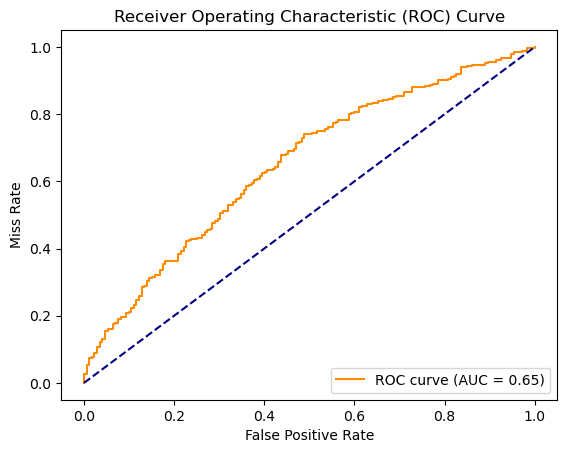

AUC value: 0.650252780586451


In [8]:
#获得正样本的groundtruth
boxes_truth=[]
files=[]
filepath=r'E:\dataset\INRIA Person Dataset\person_1\INRIAPerson\Test\annotations'
files.extend([os.path.join(filepath, f).replace('\\','/') for f in os.listdir(filepath)])
for file in files:
    with open(file, encoding='ansi') as f:
        contents = f.read()
        obj=re.compile(r"\(Xmin, Ymin\) - \(Xmax, Ymax\) : \((?P<x1>\d+), (?P<y1>\d+)\) - \((?P<x2>\d+), (?P<y2>\d+)\)",re.S)
        resp=re.findall(obj,contents)
        truth_rec=np.array(resp)
        truth_rec=truth_rec.astype(int)
        boxes_truth.append(truth_rec)   

#获得用于画出AOU曲线的truth_labels和pred_scores
truth_labels=[]
pred_scores=[]
for i in range(len(boxes_predict)):
    for j in range(len(boxes_predict[i])):
        pred_scores.append(scores_predict[i][j])
        iou_lst=compute_iou(boxes_predict[i][j],boxes_truth[i])
        flag=False
        for iou in iou_lst:
            if iou>0.1:
                flag=True
                break
        if flag:
            truth_labels.append(1)
        else:
            truth_labels.append(0)

# 计算FPR和Miss Rate
fpr, miss_rate, thresholds = roc_curve(truth_labels, pred_scores)

# 绘制ROC曲线
plt.plot(fpr, miss_rate, color='darkorange', label='ROC curve (AUC = %0.2f)' % auc(fpr, miss_rate))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('Miss Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 计算AUC值
auc_value = auc(fpr, miss_rate)
print('AUC value:', auc_value)